<a href="https://colab.research.google.com/github/Pbrillan/CEIA/blob/main/VPC2/TP2_VP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio Práctico - Clase 2 VPC2 - 4co2021

Generar una red convolucional con las siguientes caracteristicas:

*   Conv1: cantidad de filtros=16, tramaño de filtro=3, stride=1, padding="same"
*   Pool1: MaxPooling, tamaño de filtro=2, stride=2
*   Conv2: cantidad de filtros=32, tramaño de filtro=3, stride=1, padding="same"
*   Pool2: MaxPooling, tamaño de filtro=2, stride=2
*   Conv3: cantidad de filtros=64, tramaño de filtro=3, stride=1, padding="same"
*   Pool3: MaxPooling, tamaño de filtro=2, stride=2
*   Conv4: cantidad de filtros=128, tramaño de filtro=3, stride=1, padding="same"
*   Linear1: cantidad de neuronas=100
*   Linear2: capa de salida

Elegir la función de activación que crean mas conveniente.

Ejercicios:

1.   Utilizando el dataset CIFAR10, provisto por PyTorch, entrenar la red sin aplicar data augmentation durante, al menos, 20 epocas. Se produce sobreentrenamiento?
2.   Utilizando el mismo dataset y aplicando las tecnicas de data augmentation que considere necesarias, entrenar nuevamente la red durante, al menos, 20 epocas sin que se produzca sobreentrenamiento hasta alcanzar un accuracy de 80% aproximadamente.
3.   A partir de los resultados obtenidos en los puntos anteriores: ¿Por qué cree que en el segundo caso el ritmo de mejora de la red es mas lento que en el primero?




In [ ]:
#Lib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision
import torchsummary
!pip install torchmetrics
import torchmetrics
from torchvision.datasets import CIFAR10


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 17.6 MB/s 


In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=32)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                   [-1, 32]          16,416
Total params: 5,422,784
Trainable params: 5,422,784
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.69
Estima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##sin transformaciones


In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(size=(150, 150)),
     ])

batch_size = 32


train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int(len(train_data) * 0.8) # 80% training data
valid_size = len(train_data) - train_size # 20% validation data
train_set, valid_set = torch.utils.data.random_split(train_data, [train_size, valid_size])


test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model_loss = torch.nn.CrossEntropyLoss()

conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model_optimizer.zero_grad()
    #print(train_target)
    output = conv_model(train_data)
    
    loss = conv_model_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model_optimizer.step()

    accuracy = conv_model_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model(valid_data)
    epoch_valid_loss += conv_model_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 1/20 - Train loss 1.568364 - Train Accuracy 0.431650 - Valid Loss 1.218442 - Valid Accuracy 0.556310
Epoch: 2/20 - Train loss 1.088752 - Train Accuracy 0.611850 - Valid Loss 1.024311 - Valid Accuracy 0.635683
Epoch: 3/20 - Train loss 0.849797 - Train Accuracy 0.702525 - Valid Loss 0.970252 - Valid Accuracy 0.659645
Epoch: 4/20 - Train loss 0.651131 - Train Accuracy 0.772725 - Valid Loss 0.961258 - Valid Accuracy 0.685104
Epoch: 5/20 - Train loss 0.456314 - Train Accuracy 0.838350 - Valid Loss 0.977776 - Valid Accuracy 0.699481
Epoch: 6/20 - Train loss 0.287053 - Train Accuracy 0.899900 - Valid Loss 1.164185 - Valid Accuracy 0.686302
Epoch: 7/20 - Train loss 0.176936 - Train Accuracy 0.937875 - Valid Loss 1.489095 - Valid Accuracy 0.678215
Epoch: 8/20 - Train loss 0.123400 - Train Accuracy 0.956475 - Valid Loss 1.645913 - Valid Accuracy 0.678814
Epoch: 9/20 - Train loss 0.107996 - Train Accuracy 0.963475 - Valid Loss 1.837820 - Valid Accuracy 0.676717
Epoch: 10/20 - Train loss 0.

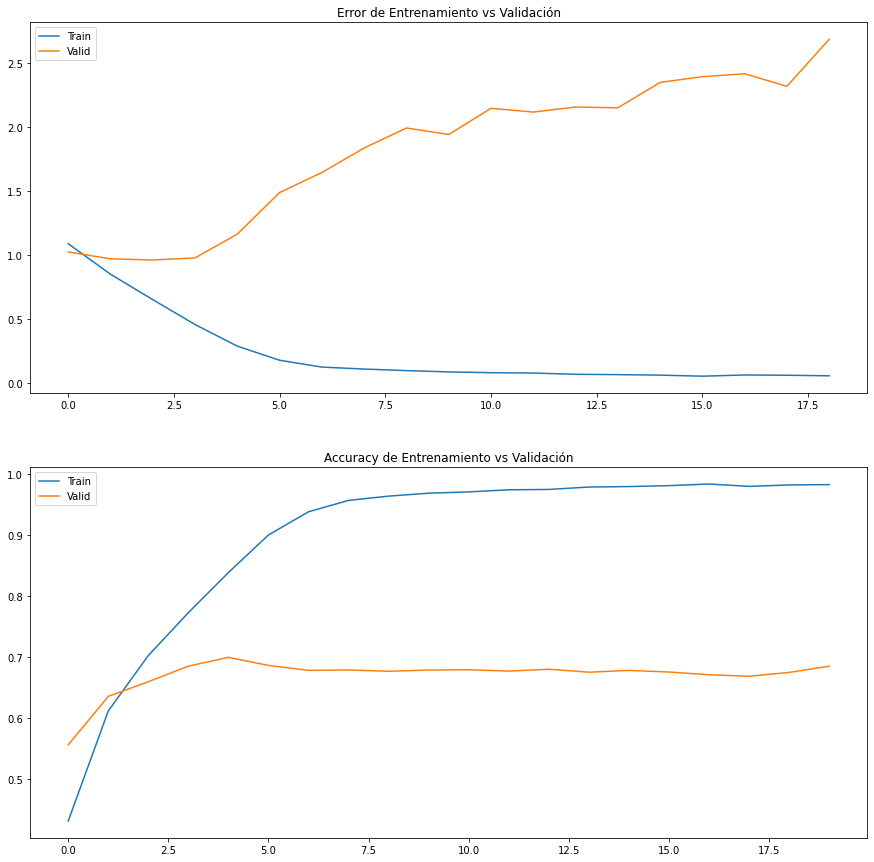

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Se aprecia que se sobreentrena rapidamente

##Con transformaciones 






Dataset de validation sin transformaciones



In [ ]:
conv_model2 = ConvModel()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model2.to("cuda")


In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5),
     torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.7, 1.0)),
     #torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
     #torchvision.transforms.RandomPerspective(p=0.25),
     #torchvision.transforms.RandomSolarize(p=0.5,threshold=0.5),
     #torchvision.transforms.RandomAutocontrast(p=0.5),
     #torchvision.transforms.RandomEqualize(p=0.5),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(size=(150, 150)),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transformtest = torchvision.transforms.Compose(
    [#torchvision.transforms.RandomHorizontalFlip(p=0.5),
     #torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.7, 1.0)),
     #torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
     #torchvision.transforms.RandomPerspective(p=0.25),
     #torchvision.transforms.RandomSolarize(p=0.5,threshold=0.5),
     #torchvision.transforms.RandomAutocontrast(p=0.5),
     #torchvision.transforms.RandomEqualize(p=0.5),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(size=(150, 150))])

batch_size = 32


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#train_size = int(len(train_data) * 0.8) # 80% training data
#valid_size = len(train_data) - train_size # 20% validation data
#train_set, valid_set = torch.utils.data.random_split(train_data, [train_size, valid_size])


valid_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformtest)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
conv_model2_optimizer = torch.optim.Adam(conv_model2.parameters(), lr=0.001)

conv_model2_loss = torch.nn.CrossEntropyLoss()

conv_model2_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model2_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 30

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model2_optimizer.zero_grad()
    #print(train_target)
    output = conv_model2(train_data)
    
    loss = conv_model2_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model2_optimizer.step()

    accuracy = conv_model2_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model2(valid_data)
    epoch_valid_loss += conv_model2_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model2_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 1/30 - Train loss 1.485801 - Train Accuracy 0.462712 - Valid Loss 2.705882 - Valid Accuracy 0.208167
Epoch: 2/30 - Train loss 1.082140 - Train Accuracy 0.617982 - Valid Loss 1.852181 - Valid Accuracy 0.366514
Epoch: 3/30 - Train loss 0.890377 - Train Accuracy 0.688980 - Valid Loss 1.544280 - Valid Accuracy 0.451178
Epoch: 4/30 - Train loss 0.788032 - Train Accuracy 0.724188 - Valid Loss 1.562895 - Valid Accuracy 0.467851
Epoch: 5/30 - Train loss 0.709440 - Train Accuracy 0.752399 - Valid Loss 1.533176 - Valid Accuracy 0.466853
Epoch: 6/30 - Train loss 0.653344 - Train Accuracy 0.771233 - Valid Loss 1.641171 - Valid Accuracy 0.462959
Epoch: 7/30 - Train loss 0.611592 - Train Accuracy 0.786808 - Valid Loss 1.453294 - Valid Accuracy 0.497304
Epoch: 8/30 - Train loss 0.573035 - Train Accuracy 0.801244 - Valid Loss 1.750138 - Valid Accuracy 0.456769
Epoch: 9/30 - Train loss 0.540609 - Train Accuracy 0.813840 - Valid Loss 1.422670 - Valid Accuracy 0.545028
Epoch: 10/30 - Train loss 0.

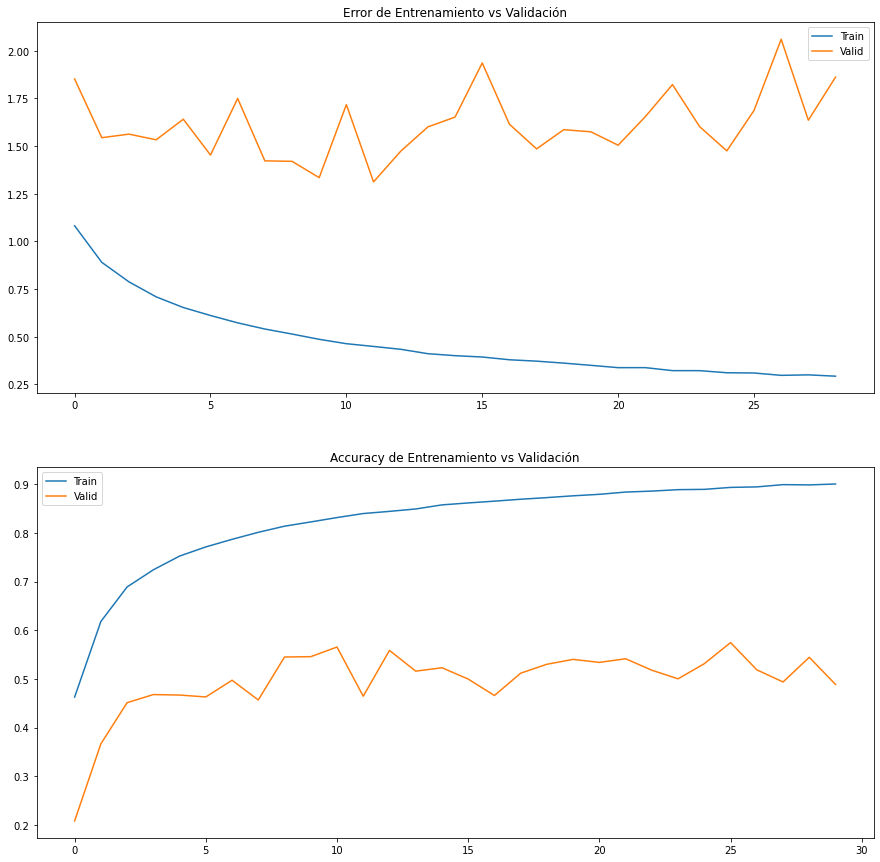

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
torch.save(conv_model2.state_dict(), "/content/drive/MyDrive/MODELO VPC2/ConTransformaciones.pkl")

In [ ]:
conv_model2_optimizer = torch.optim.Adam(conv_model2.parameters(), lr=0.001)

conv_model2_loss = torch.nn.CrossEntropyLoss()

conv_model2_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model2_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 5

# Defino listas para realizar graficas de los resultados
#train_loss = []
#train_acc = []
#valid_loss = []
#valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model2_optimizer.zero_grad()
    #print(train_target)
    output = conv_model2(train_data)
    
    loss = conv_model2_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model2_optimizer.step()

    accuracy = conv_model2_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model2(valid_data)
    epoch_valid_loss += conv_model2_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model2_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+21, epochs+20, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 21/25 - Train loss 0.316192 - Train Accuracy 0.890855 - Valid Loss 0.746394 - Valid Accuracy 0.781350
Epoch: 22/25 - Train loss 0.312817 - Train Accuracy 0.892454 - Valid Loss 0.722697 - Valid Accuracy 0.784445
Epoch: 23/25 - Train loss 0.302140 - Train Accuracy 0.896813 - Valid Loss 0.784978 - Valid Accuracy 0.771565
Epoch: 24/25 - Train loss 0.305026 - Train Accuracy 0.896733 - Valid Loss 0.756481 - Valid Accuracy 0.778255
Epoch: 25/25 - Train loss 0.293615 - Train Accuracy 0.899612 - Valid Loss 0.783258 - Valid Accuracy 0.778155


In [ ]:
conv_model2_optimizer = torch.optim.Adam(conv_model2.parameters(), lr=0.001)

conv_model2_loss = torch.nn.CrossEntropyLoss()

conv_model2_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model2_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 5

# Defino listas para realizar graficas de los resultados
#train_loss = []
#train_acc = []
#valid_loss = []
#valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model2_optimizer.zero_grad()
    #print(train_target)
    output = conv_model2(train_data)
    
    loss = conv_model2_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model2_optimizer.step()

    accuracy = conv_model2_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model2(valid_data)
    epoch_valid_loss += conv_model2_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model2_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+21, epochs+20, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 21/25 - Train loss 0.293644 - Train Accuracy 0.900872 - Valid Loss 0.715537 - Valid Accuracy 0.785843
Epoch: 22/25 - Train loss 0.295533 - Train Accuracy 0.898213 - Valid Loss 0.768078 - Valid Accuracy 0.786641
Epoch: 23/25 - Train loss 0.288510 - Train Accuracy 0.902111 - Valid Loss 0.733430 - Valid Accuracy 0.786941
Epoch: 24/25 - Train loss 0.283269 - Train Accuracy 0.903251 - Valid Loss 0.749875 - Valid Accuracy 0.784744
Epoch: 25/25 - Train loss 0.282553 - Train Accuracy 0.905550 - Valid Loss 0.742476 - Valid Accuracy 0.784445


##Con transformaciones 2

train y validation con la misma transformacion

In [ ]:
conv_model2 = ConvModel()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model2.to("cuda")


In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5),
     torchvision.transforms.RandomResizedCrop(size=(150, 150), scale=(0.7, 1.0)),
     #torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
     #torchvision.transforms.RandomPerspective(p=0.25),
     #torchvision.transforms.RandomSolarize(p=0.5,threshold=0.5),
     #torchvision.transforms.RandomAutocontrast(p=0.5),
     #torchvision.transforms.RandomEqualize(p=0.5),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize(size=(150, 150)),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#train_size = int(len(train_data) * 0.8) # 80% training data
#valid_size = len(train_data) - train_size # 20% validation data
#train_set, valid_set = torch.utils.data.random_split(train_data, [train_size, valid_size])


valid_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
conv_model2_optimizer = torch.optim.Adam(conv_model2.parameters(), lr=0.001)

conv_model2_loss = torch.nn.CrossEntropyLoss()

conv_model2_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model2_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 30

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model2_optimizer.zero_grad()
    #print(train_target)
    output = conv_model2(train_data)
    
    loss = conv_model2_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model2_optimizer.step()

    accuracy = conv_model2_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model2(valid_data)
    epoch_valid_loss += conv_model2_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model2_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 1/30 - Train loss 1.481059 - Train Accuracy 0.465611 - Valid Loss 1.170701 - Valid Accuracy 0.582169
Epoch: 2/30 - Train loss 1.067242 - Train Accuracy 0.621641 - Valid Loss 0.988188 - Valid Accuracy 0.648862
Epoch: 3/30 - Train loss 0.892112 - Train Accuracy 0.683661 - Valid Loss 0.866584 - Valid Accuracy 0.698482
Epoch: 4/30 - Train loss 0.791149 - Train Accuracy 0.724008 - Valid Loss 0.814142 - Valid Accuracy 0.715655
Epoch: 5/30 - Train loss 0.722892 - Train Accuracy 0.746801 - Valid Loss 0.779842 - Valid Accuracy 0.726338
Epoch: 6/30 - Train loss 0.670887 - Train Accuracy 0.766555 - Valid Loss 0.802849 - Valid Accuracy 0.726038
Epoch: 7/30 - Train loss 0.631269 - Train Accuracy 0.780630 - Valid Loss 0.739717 - Valid Accuracy 0.748902
Epoch: 8/30 - Train loss 0.591267 - Train Accuracy 0.793446 - Valid Loss 0.732147 - Valid Accuracy 0.758287
Epoch: 9/30 - Train loss 0.559987 - Train Accuracy 0.805042 - Valid Loss 0.730565 - Valid Accuracy 0.760783
Epoch: 10/30 - Train loss 0.

In [ ]:
torch.save(conv_model2.state_dict(), "/content/drive/MyDrive/MODELO VPC2/ConTransformaciones2.pkl")

In [ ]:
conv_model2_optimizer = torch.optim.Adam(conv_model2.parameters(), lr=0.001)

conv_model2_loss = torch.nn.CrossEntropyLoss()

conv_model2_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  conv_model2_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 30

# Defino listas para realizar graficas de los resultados
#train_loss = []
#train_acc = []
#valid_loss = []
#valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Al igual que con el modelo, los datos también se deben pasar a la GPU
    if torch.cuda.is_available():
      train_data = train_data.to("cuda")
      train_target = train_target.to("cuda")

    conv_model2_optimizer.zero_grad()
    #print(train_target)
    output = conv_model2(train_data)
    
    loss = conv_model2_loss(output, train_target)
    epoch_train_loss += loss.item()
    loss.backward()
    
    conv_model2_optimizer.step()

    accuracy = conv_model2_accuracy(output, train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for valid_data, valid_target in valid_loader:
    if torch.cuda.is_available():
      valid_data = valid_data.to("cuda")
      valid_target = valid_target.to("cuda")

    output = conv_model2(valid_data)
    epoch_valid_loss += conv_model2_loss(output, valid_target).item()
    epoch_valid_accuracy += conv_model2_accuracy(output, valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+21, epochs+20, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))


Epoch: 21/50 - Train loss 0.310701 - Train Accuracy 0.894814 - Valid Loss 0.767906 - Valid Accuracy 0.771466
Epoch: 22/50 - Train loss 0.302708 - Train Accuracy 0.896793 - Valid Loss 0.746092 - Valid Accuracy 0.774661
Epoch: 23/50 - Train loss 0.298404 - Train Accuracy 0.898393 - Valid Loss 0.773204 - Valid Accuracy 0.779752
Epoch: 24/50 - Train loss 0.293526 - Train Accuracy 0.899632 - Valid Loss 0.768882 - Valid Accuracy 0.776458
Epoch: 25/50 - Train loss 0.289187 - Train Accuracy 0.901771 - Valid Loss 0.771726 - Valid Accuracy 0.776857
Epoch: 26/50 - Train loss 0.285584 - Train Accuracy 0.902711 - Valid Loss 0.819797 - Valid Accuracy 0.770667
Epoch: 27/50 - Train loss 0.283720 - Train Accuracy 0.903951 - Valid Loss 0.782542 - Valid Accuracy 0.778854
Epoch: 28/50 - Train loss 0.281407 - Train Accuracy 0.905390 - Valid Loss 0.806905 - Valid Accuracy 0.774960
Epoch: 29/50 - Train loss 0.272726 - Train Accuracy 0.907110 - Valid Loss 0.846303 - Valid Accuracy 0.775260
Epoch: 30/50 - Trai

In [ ]:
torch.save(conv_model2.state_dict(), "/content/drive/MyDrive/MODELO VPC2/ConTransformaciones2.pkl")

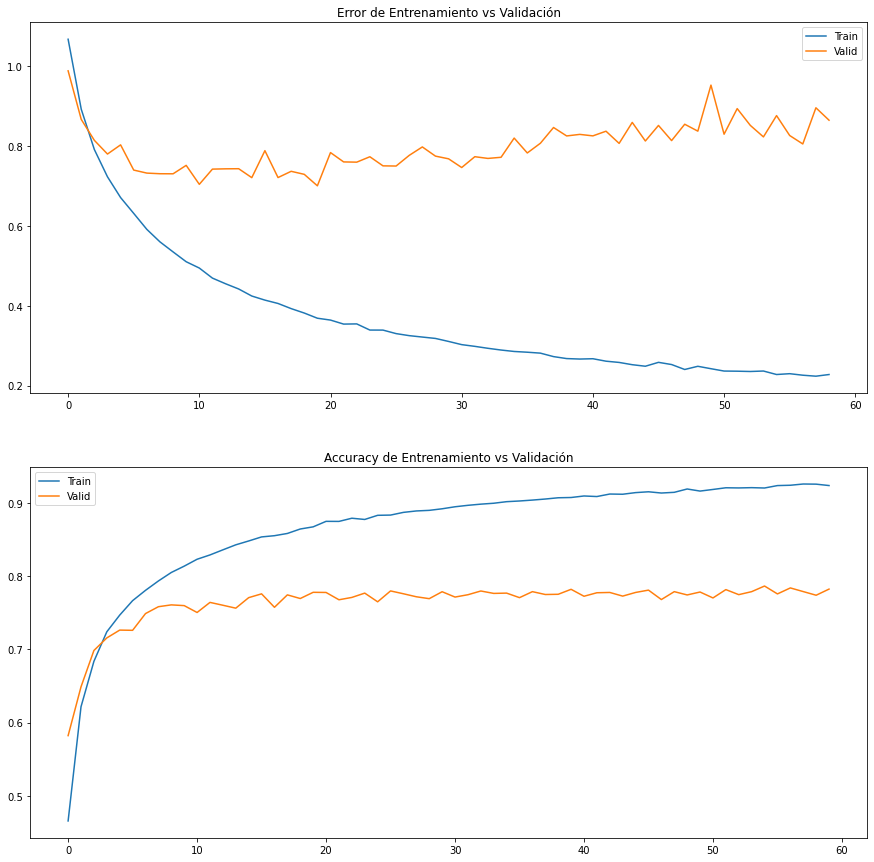

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

#Conclusiones

el ritmo de mejora es mas lento porque con data augmentation aprende caracteristica mas generales y no se sobreentrena tan rapidamente ya que el dataset de train cambia en cada epoch